In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [10]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]
X_train.shape

(55000, 28, 28)

In [16]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))
    
class Stacked_encoder:
    def __init__(self):
        self.stacked_encoder = keras.models.Sequential([
            keras.layers.Flatten(input_shape=[28, 28]),
            keras.layers.Dense(100, activation="selu"),
            keras.layers.Dense(30, activation="selu"),
        ])
        self.stacked_decoder = keras.models.Sequential([
            keras.layers.Dense(100, activation="selu", input_shape=[30]),
            keras.layers.Dense(28 * 28, activation="sigmoid"),
            keras.layers.Reshape([28, 28])
        ])
        self.model = keras.models.Sequential([self.stacked_encoder, self.stacked_decoder])
    
    def get_model(self):
        return self.model

stacked_ae = Stacked_encoder()
stacked_ae.get_model().compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.get_model().fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3374 - rounded_accuracy: 0.8876 - val_loss: 0.3182 - val_rounded_accuracy: 0.8979
Epoch 2/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3049 - rounded_accuracy: 0.9160 - val_loss: 0.3011 - val_rounded_accuracy: 0.9208
Epoch 3/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2981 - rounded_accuracy: 0.9220 - val_loss: 0.2980 - val_rounded_accuracy: 0.9253
Epoch 4/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2941 - rounded_accuracy: 0.9254 - val_loss: 0.2940 - val_rounded_accuracy: 0.9252
Epoch 5/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2914 - rounded_accuracy: 0.9278 - val_loss: 0.2913 - val_rounded_accuracy: 0.9286
Epoch 6/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2894 - rounded_accuracy: 0.9295 - val_loss: 0.2897 - val_rounded_accuracy: 0.9316
Epoch 7/20
1719/1719 [==================

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 30)                81530     
                                                                 
 sequential_4 (Sequential)   (None, 28, 28)            82284     
                                                                 
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
_________________________________________________________________


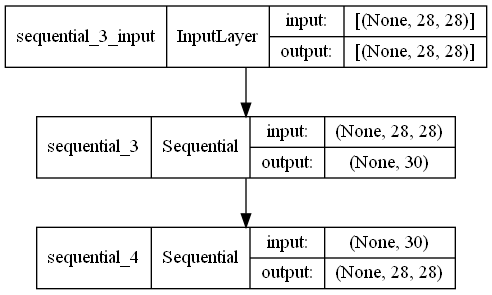

In [17]:
stacked_ae.get_model().summary()
keras.utils.plot_model(stacked_ae.get_model(), "my_fashion_mnist_model.png", show_shapes=True)

Saving figure reconstruction_plot


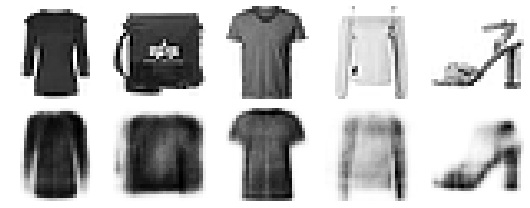

In [18]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
show_reconstructions(stacked_ae.get_model())
save_fig("reconstruction_plot")

In [ ]:
# 가중치 묶기

In [11]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3269 - rounded_accuracy: 0.8960 - val_loss: 0.3081 - val_rounded_accuracy: 0.9079
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2975 - rounded_accuracy: 0.9224 - val_loss: 0.2951 - val_rounded_accuracy: 0.9285
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2920 - rounded_accuracy: 0.9275 - val_loss: 0.3015 - val_rounded_accuracy: 0.9091
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2889 - rounded_accuracy: 0.9302 - val_loss: 0.2880 - val_rounded_accuracy: 0.9332
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2865 - rounded_accuracy: 0.9324 - val_loss: 0.2874 - val_rounded_accuracy: 0.9315
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2850 - rounded_accuracy: 0.9340 - val_loss: 0.2862 - val_rounded_accuracy: 0.9353
Epoch 7/10
1719/1719 [==================

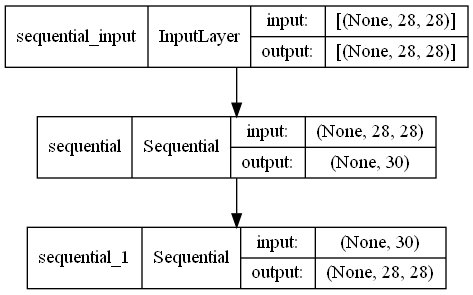

In [13]:
keras.utils.plot_model(tied_ae, "my_fashion_mnist_model.png", show_shapes=True)

In [ ]:
# 결과물 시각화

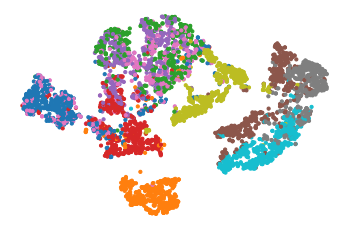

In [20]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_ae.stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

In [24]:
# 합성곱

tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
# history = conv_ae.fit(X_train, X_train, epochs=5,
#                       validation_data=(X_valid, X_valid))

In [32]:
# 합성곱

tf.random.set_seed(42)
np.random.seed(42)

class Conv_ae:
    
    def __init__(self):
        
        self.encoder = keras.models.Sequential([
                keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
                keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
                keras.layers.MaxPool2D(pool_size=2),
                keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
                keras.layers.MaxPool2D(pool_size=2),
                keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
                keras.layers.MaxPool2D(pool_size=2)
            ])
        
        self.decoder = keras.models.Sequential([
                keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                            input_shape=[3, 3, 64]),
                keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
                keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
                keras.layers.Reshape([28, 28])
            ])
        
        self.model =  keras.models.Sequential([
            keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
            keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
            keras.layers.MaxPool2D(pool_size=2),
            keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
            keras.layers.MaxPool2D(pool_size=2),
            keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
            keras.layers.MaxPool2D(pool_size=2),
            keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
            keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
            keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
            keras.layers.Reshape([28, 28])
        ])

        self.model = keras.models.Sequential([conv_encoder, conv_decoder])
        
    def get_model(self):
        return self.model
    
conv_ae_instance=Conv_ae()
conv_ae=conv_ae_instance.get_model()
encoder=conv_ae_instance.encoder
decoder=conv_ae_instance.decoder
conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

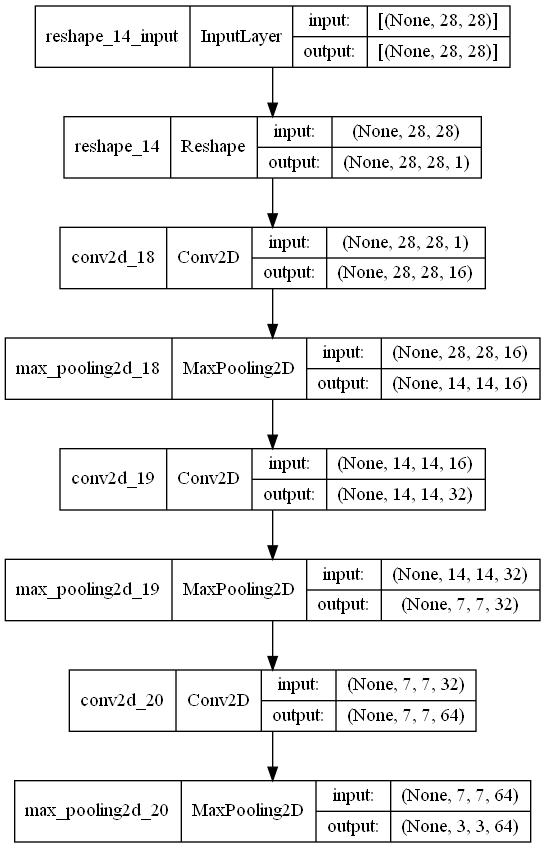

In [33]:
keras.utils.plot_model(encoder, "my_fashion_mnist_model.png", show_shapes=True)

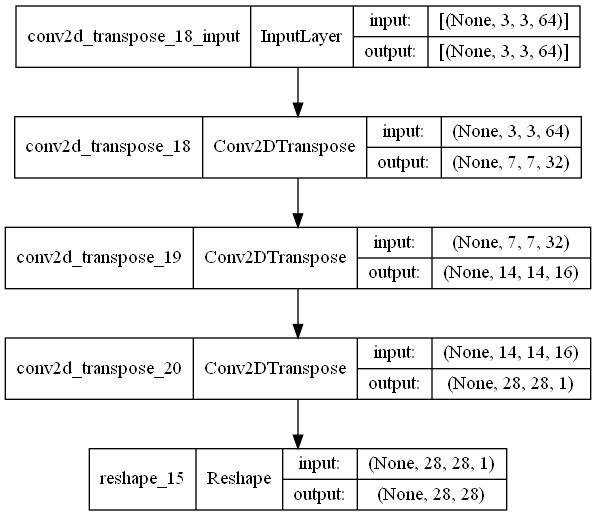

In [34]:
keras.utils.plot_model(decoder, "my_fashion_mnist_model.png", show_shapes=True)

In [37]:
class RNNae:
    def __init__(self):
        self.recurrent_encoder = keras.models.Sequential([
            keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
            keras.layers.LSTM(30)
        ])
        self.recurrent_decoder = keras.models.Sequential([
            keras.layers.RepeatVector(28, input_shape=[30]),
            keras.layers.LSTM(100, return_sequences=True),
            keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
        ])
        self.model = keras.models.Sequential([self.recurrent_encoder, self.recurrent_decoder])

recurrent_ae_instance = RNNae()
recurrent_ae = recurrent_ae_instance.model
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 41s 22ms/step - loss: 0.5048 - rounded_accuracy: 0.7685 - val_loss: 0.4361 - val_rounded_accuracy: 0.8235
Epoch 2/10
1719/1719 [==============================] - 36s 21ms/step - loss: 0.3928 - rounded_accuracy: 0.8505 - val_loss: 0.3731 - val_rounded_accuracy: 0.8586
Epoch 3/10
1719/1719 [==============================] - 36s 21ms/step - loss: 0.3611 - rounded_accuracy: 0.8734 - val_loss: 0.3540 - val_rounded_accuracy: 0.8838
Epoch 4/10
1719/1719 [==============================] - 36s 21ms/step - loss: 0.3473 - rounded_accuracy: 0.8839 - val_loss: 0.3500 - val_rounded_accuracy: 0.8805
Epoch 5/10
1719/1719 [==============================] - 37s 21ms/step - loss: 0.3381 - rounded_accuracy: 0.8894 - val_loss: 0.3341 - val_rounded_accuracy: 0.8931
Epoch 6/10
1719/1719 [==============================] - 36s 21ms/step - loss: 0.3314 - rounded_accuracy: 0.8937 - val_loss: 0.3303 - val_rounded_accuracy: 0.8976
Epoch 7/10
1719/1719 [======

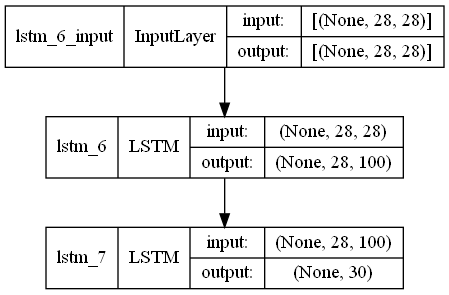

In [38]:
encoder = recurrent_ae_instance.recurrent_encoder
keras.utils.plot_model(encoder, "my_fashion_mnist_model.png", show_shapes=True)

In [39]:
# stacked denoising autoencoder

class Denosing_ae:
    def __init__(self):
        self.denoising_encoder = keras.models.Sequential([
            keras.layers.Flatten(input_shape=[28, 28]),
            keras.layers.GaussianNoise(0.2), #또는 keras.layers.Dropout(0.5)
            keras.layers.Dense(100, activation="selu"),
            keras.layers.Dense(30, activation="selu")
        ])
        self.denoising_decoder = keras.models.Sequential([
            keras.layers.Dense(100, activation="selu", input_shape=[30]),
            keras.layers.Dense(28 * 28, activation="sigmoid"),
            keras.layers.Reshape([28, 28])
        ])
        self.model = keras.models.Sequential([self.denoising_encoder, self.denoising_decoder])

denoising_ae = Denosing_ae().model
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3485 - rounded_accuracy: 0.8786 - val_loss: 0.3187 - val_rounded_accuracy: 0.9046
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3132 - rounded_accuracy: 0.9089 - val_loss: 0.3096 - val_rounded_accuracy: 0.9157
Epoch 3/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3059 - rounded_accuracy: 0.9152 - val_loss: 0.3030 - val_rounded_accuracy: 0.9187
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3017 - rounded_accuracy: 0.9188 - val_loss: 0.2991 - val_rounded_accuracy: 0.9230
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2987 - rounded_accuracy: 0.9214 - val_loss: 0.2968 - val_rounded_accuracy: 0.9244
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2966 - rounded_accuracy: 0.9232 - val_loss: 0.2950 - val_rounded_accuracy: 0.9278
Epoch 7/10
1719/1719 [==================

In [42]:
#gan
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")


In [41]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()                                                    # not shown